In [ ]:
import matplotlib.pyplot as plt
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from deepface import DeepFace
import numpy as np
import pandas as pd
import pathlib
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

24-04-04 22:54:08 - Directory /root/.deepface created
24-04-04 22:54:08 - Directory /root/.deepface/weights created


In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.3/94.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=1ee8fb9f2dd8bbd6bc6462922a20c15490d9ac3c7e2b5a740ae4fb1f680366e3
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire


In [ ]:
backends = [
  'opencv',
  'ssd',
  'dlib',
  'mtcnn',
  'retinaface',
  'mediapipe',
  'yolov8',
  'yunet',
  'fastmtcnn',
]

lst = os.listdir('train/') # your directory path
number_files = len(lst)
noFace = 0
'''
for index in range(number_files):
    img_path = 'train/'+str(index)+'.jpg'
    try:
        img = DeepFace.detectFace(img_path,target_size = (224, 224), detector_backend = backends[6])
    except ValueError:
        noFace = noFace + 1
        continue
    #plt.imshow(img)
    #plt.show()
print(noFace)
'''
''' Creating the Path for the files
df = pd.read_csv('category.csv')
for name in df.get('Category'):
    path = os.path.join("db/",name)
    os.mkdir(path)
    print(name)
'''
#Splicing faceshots and putting them into correct files
'''
df = pd.read_csv('train.csv')
for index in range(number_files):
    img_path = 'train/'+str(index)+'.jpg'
    try:
        img = DeepFace.detectFace(img_path,target_size = (224, 224), detector_backend = backends[6])
    except ValueError:
        noFace = noFace + 1
        continue
    im = Image.fromarray((img * 255).astype(np.uint8))
    im.save('db/'+str(df.get('Category')[index])+'/'+str(df.get('File Name')[index]))
'''

FileNotFoundError: [Errno 2] No such file or directory: 'train/'

In [ ]:
data_dir = "db/db/"
data_dir = pathlib.Path(data_dir).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

img = Image.open('db/db/Aaron Judge/11.jpg')
print(img.size)
batch_size = 128
img_height = 224
img_width = 224

66466
(224, 224)


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 66466 files belonging to 100 classes.
Using 53173 files for training.
Found 66466 files belonging to 100 classes.
Using 13293 files for validation.


In [ ]:
class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(100).prefetch(buffer_size=1)
val_ds = val_ds.prefetch(buffer_size=1)
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
num_classes = len(class_names)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
model = tf.keras.models.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [ ]:
epochs=7
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/7
416/416 [==============================] - 861s 2s/step - loss: 4.3837 - accuracy: 0.0439 - val_loss: 4.0233 - val_accuracy: 0.0928
Epoch 2/7
416/416 [==============================] - 909s 2s/step - loss: 3.8236 - accuracy: 0.1360 - val_loss: 3.5743 - val_accuracy: 0.1959
Epoch 3/7
416/416 [==============================] - ETA: 0s - loss: 3.5132 - accuracy: 0.2063

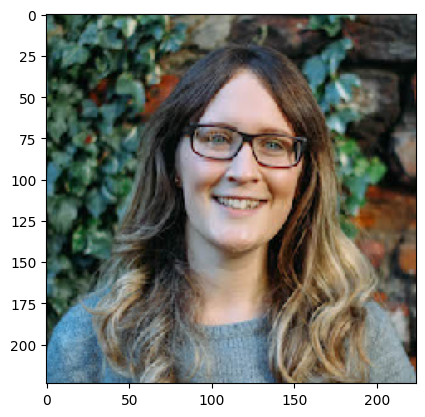

TypeError: Invalid shape (1, 224, 224, 3) for image data

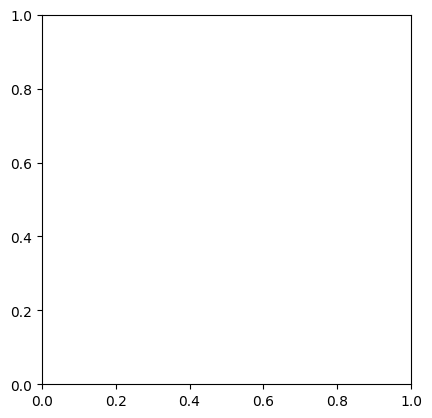

In [ ]:
for index in range(4977):
    img = DeepFace.detectFace('test/test/'+str(index)+'.jpg',target_size = (224, 224), detector_backend = backends[6])
    #img = tf.keras.utils.load_img('test/test/'+str(index)+'.jpg', target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)

    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )